In [1]:
import matplotlib.pyplot as plt
from scipy import interpolate
import numpy as np
import scipy.io
from scipy import signal
import math
from scipy import integrate
import matplotlib.animation as animation

In [2]:
def file_parser(file_n):
    # Function to load the file
    info = scipy.io.loadmat(file_n)
    return info

In [3]:
contrast_file = file_parser('/content/drive/MyDrive/BE 530/contrast_response.mat')
#contrast_file = file_parser('contrast_response.mat')

In [4]:
delta_t = 1/2000

# Question 1

**(a) Display a plot of the spikes in the first 20 seconds of the trial with the highest contrast.**



In [5]:
def spike_counter(contrast_file,delta_t,trial,t_time,mode):
  y_data = np.zeros(int(t_time/delta_t))
  x_data = np.arange(int(t_time/delta_t))
  x_data_seconds = x_data*delta_t
  spiketimes = []
  if mode == 'graph':
    for i in range(len(y_data)):
        if i in contrast_file['spikeTimes'][0][trial]:
          y_data[i] = 1
    return(x_data,y_data,x_data_seconds)
  elif mode == 'times':
    for i in range(len(y_data)):
        if i in contrast_file['spikeTimes'][0][trial]:
          spiketimes.append(i)
    return x_data,spiketimes


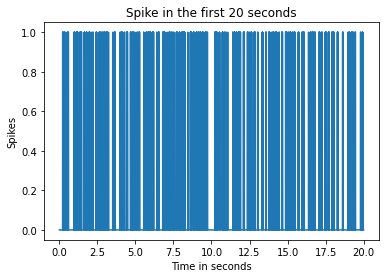

In [6]:
x_data, y_data, x_data_seconds = spike_counter(contrast_file,delta_t,8,20,'graph')
plt.plot(x_data_seconds,y_data)
plt.title('Spike in the first 20 seconds')
plt.xlabel('Time in seconds')
plt.ylabel('Spikes')
plt.show()

**(b) For the trial with the highest contrast, plot the time-binned firing rate for the first 20 seconds. To do that you can use the output of MATLAB’s histogram function. Use 100ms time bins. Be sure to scale the output so that the firing rate is measured in spikes/s.**


90.0


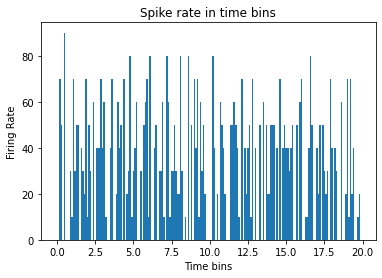

In [7]:
previous = 0
counter = 0
time_bins = []
time_bins_time = [0]
for i in range(int(0.1/delta_t),len(x_data),int(0.100/delta_t)):
    time_bins_time.append(i)
    counter = 0
    for j in range(previous,i):
        if y_data[j] != 0:
            counter += 1
    previous = i
    time_bins.append(counter/0.100)
time_bins_time = [i * delta_t for i in time_bins_time]
print(max(time_bins))
plt.bar(time_bins_time[:199],time_bins,width= 0.1)
plt.xlabel('Time bins')
plt.ylabel('Firing Rate')
plt.title('Spike rate in time bins')
#plt.hist(y_data,x_data_seconds)
plt.show()

**(c) The firing rate of a neuron is often estimated by assuming it changes smoothly across time. Accordingly, a common step before further analyses are done is to smooth the spike vector (i.e. a binary vector with 0 indicating there is no spike recorded during a particular sample, and 1 indicating there was a spike recorded at said sample) rather than using set bins as we did in problem problem (1.b). This smoothing is done by convolving the spike vector with a Gaussian with a set standard deviation; for our purposes 35 ms will work well for the latter. Also note, the normalization is important here: ensure that the values in each Gaussian sum up to the sampling rate. MATLAB and Python both have their own built-in convolution functions that you can use. Pay attention to the input arguments for these functions, in particular, their order; you will need them again for later questions.**


In [8]:
def gauss_filter(sigma,sampling_rate):
  norm_f = sigma*sampling_rate
  gauss_window = signal.windows.gaussian(8*norm_f, std=0.035*2000)
  x_d = np.arange(0,len(gauss_window),1)

  #plt.plot(gauss_window)
  return(gauss_window/math.sqrt(2*math.pi))

Text(0.5, 1.0, 'Gaussian filter')

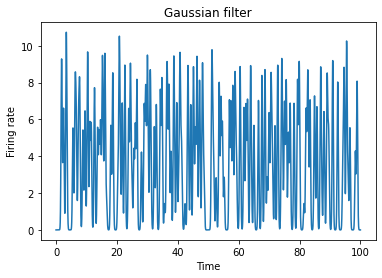

In [9]:
sigma = 0.035
gauss_window = gauss_filter(sigma,(1/delta_t))
filtered_data = signal.convolve(y_data,gauss_window)

filtered_data = 2000*(filtered_data/(8*sigma*(1/delta_t)))
plt.plot(np.linspace(0,100,len(filtered_data)),filtered_data[:])
plt.xlabel('Time')
plt.ylabel('Firing rate')
plt.title('Gaussian filter')

**(d) Plot the overall average firing rate as a function of contrast.**


Text(0.5, 1.0, 'Firing rate vs contrasts')

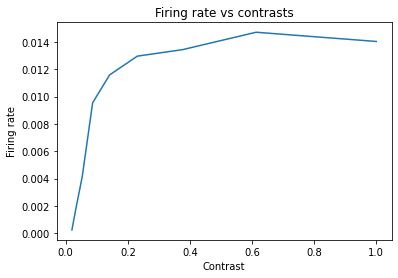

In [10]:
x_data_contrast = []
y_data_contrast = []
for i in range(len(contrast_file['contrasts'])):
  x_data_contrast.append(contrast_file['contrasts'][i][0])
  #temp_x,temp_y,x_temp2 = spike_counter(contrast_file,delta_t,i,20,'graph')
  #y_data_contrast.append(sum(temp_y)/len(temp_y))
  y_data_contrast.append(len(contrast_file['spikeTimes'][0][i])/len(contrast_file['stimulus']))
plt.plot(x_data_contrast,y_data_contrast)
plt.xlabel('Contrast')
plt.ylabel('Firing rate')
plt.title('Firing rate vs contrasts')


**(e) Generate and plot the spike-triggered averages for all nine different contrast levels. Normalize each of them so that the sum of the squared values is one. You will have to find out how far back in the past from the spikes you have to go to catch the complete spike-triggered average.**


In [11]:
def sta_total(contrast_file,delta_t,trial,tau):
  sum_sta=0
  #temp_x,temp_times = spike_counter(contrast_file,delta_t,trail,100,'times')
  #
  for i in contrast_file['spikeTimes'][0][trial]:
    if i>(tau/delta_t):
      #print(i)
      s_t = contrast_file['stimulus'][i[0]-int((tau/delta_t))][0]
      #print(int(tau/delta_t))
      sum_sta += s_t
      #print(s_t)
  #print(s_t)
  sta_final = sum_sta/(len(contrast_file['spikeTimes'][0][trial]))
  #print(sum_sta)
  return sta_final

Text(0.5, 1.0, 'STA for all trials')

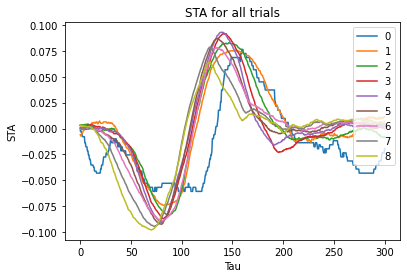

In [12]:
y_sta =[]
x_sta = []
x_sta_final = []
y_sta_final = []
k=0
for i in range(len(contrast_file['contrasts'])):
  y_sta = []
  x_sta = []
  #print(i)
  r= np.linspace(0,300,600)
  for j in r:
    y_sta.append(sta_total(contrast_file,delta_t,i,j/1000))
    x_sta.append(300-j)

  sq_sum = sum(g*g for g in y_sta)
  norm_factor = sq_sum**0.5
  y_sta =y_sta/norm_factor

  x_sta_final.append(x_sta)
  y_sta_final.append(y_sta)
  plt.plot(x_sta,y_sta[::-1],label = i)
plt.legend(loc = 'upper right')
plt.xlabel('Tau')
plt.ylabel('STA')
plt.title('STA for all trials')
#figure(figsize=(8, 6), dpi=80)


**(f) Describe how the spike-triggered average changes with contrast. What does that tell us about the behavior of this retinal ganglion cell?**

*   We see that at lower contrasts, the STA has more of a step like structure. This is smoothed at higher contrasts. The reason for this could be the lower number of spikes at lower contrasts, leading to the stepped output.
*   As the contrast increases, we see that the STA reduces a little. That is, theres is a lower time gap between a spike and a preceding spike. We see this in the graph. The negative peak comes closer to 0 as the contrast increases.

This could mean that the retinal ganglion cell responds to high contrasts well. When there is higher contrasts, the cell is more likely to spike. This could be the main intended behaviour of the retinal ganglioin cell.



# Question 2

**(a) For every trial, use the corresponding STA from problem 1 as a linear filter (as described in
the lecture) to extract the trigger feature intensity as a function of time. Be sure to scale the stimulus by the
appropriate contrast value, in order to match the actual stimulus that was displayed during the experiment.
Hint: If using the conv or convn functions in MATLAB, be aware that the kernel you are convolving
with is flip from left to right before the convolution takes place. You can get around this by using the fliplr
function on the kernel before convolving.**


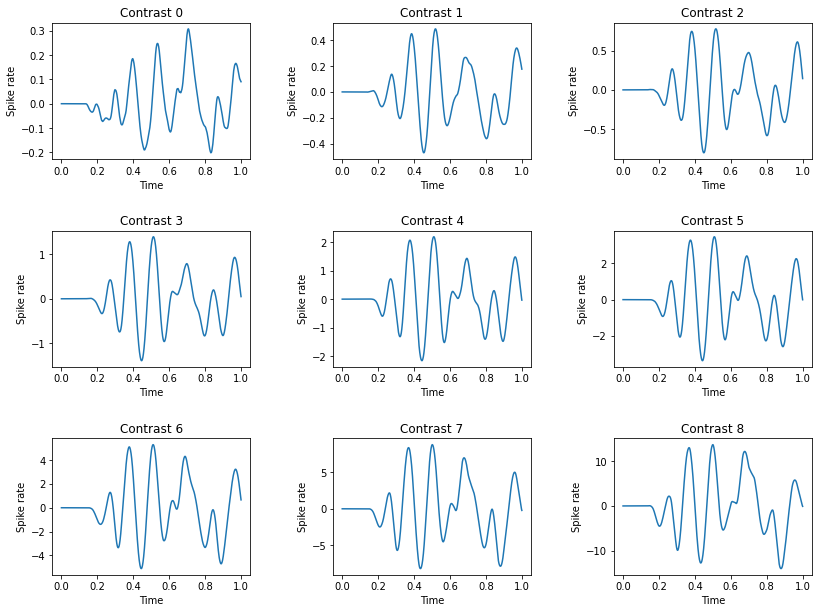

In [13]:
fig,axs = plt.subplots(3,3)
fig.tight_layout()
fig.set_figheight(9)
fig.set_figwidth(12)
filtered_data_sta_final = []
# plt.subplots_adjust(left=0.1,
#                     bottom=0.1, 
#                     right=0.9, 
#                     top=0.7, 
#                     wspace=0.4, 
#                     hspace=0.8)
for i in range(len(contrast_file['contrasts'])):
  temp_list = contrast_file['contrasts'][i][0]*contrast_file['stimulus']
  temp_list = temp_list.reshape(len(contrast_file['stimulus']))
  #print(len(y_sta_final[i]))
  a = np.zeros(270)
  temp_list = np.concatenate((a,temp_list),axis=0)
  temp_list = np.concatenate((temp_list,a),axis=0)
  #print(temp_list)
  filtered_data_sta = signal.convolve(temp_list,y_sta_final[i])
  filtered_data_sta_final.append(filtered_data_sta)
  j = i%3
  k = int(i/3)
  axs[k][j].plot(np.linspace(0,1,2000),filtered_data_sta[:2000])
  axs[k][j].set_title('Contrast ' + str(i))
  axs[k][j].set_xlabel('Time')
  axs[k][j].set_ylabel('Spike rate')


**(b) Compare your smooth spike rate curves from problem 1c with the trigger feature intensities from problem
2a. Tune the width of your Gaussian kernel until you get the best agreement between the two curves (in
terms of how smeared out the bumps in both graphs look). A good way to do that is to temporally set all
values of the trigger feature curve that are smaller than zero equal to zero so you get only positive bumps as
in the firing rate plot. Also have a look at figure 2.26. This step is essential to get good results! It should be
helpful to start with the highest intensity trial. Plot your result showing both the trigger feature intensity
graph and the smoothed spiking rates for some of the contrasts. Be sure not to introduce an artificial offset
between the two curves.
Note: The tip to set values of the trigger feature curve that are less than zero equal to zero is only
for help comparing the graphs visually. Do not have these values set to zero for the later questions. This
introduces a rectifying non-linearity before you calculate the non-linearity and will negatively impact your
answer.
Now we want to generate the static nonlinearities for all nine trials.**

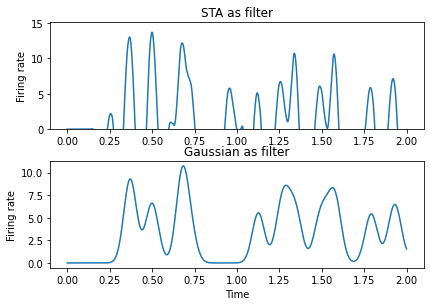

In [14]:
#new_list = []
#for i in range(len(filtered_data_sta)):
#  if filtered_data_sta[i]>=0:
#    new_list.append(filtered_data_sta)
#  else:
#    new_list.append(0)
#print(new_list[500])
fig,ax = plt.subplots(2,1)
fig.tight_layout()
ax1 = plt.subplot(2,1,1)
ax1.plot(np.linspace(0,2,4000),filtered_data_sta[:4000])
ax1.set_title('STA as filter')
ax1.set_ylabel('Firing rate')
ax1.set_ylim(bottom = 0)
ax2 = plt.subplot(2,1,2)
ax2.set_title('Gaussian as filter')
ax2.set_xlabel('Time')
ax2.set_ylabel('Firing rate')
ax2.plot(np.linspace(0,2,4000),filtered_data[:4000])

Ans. A lot of different widths were tried. The one that worked the best was 8 times the standard deviation. That is 4 lengths on either side of the gaussian kernel gave the best results. The results shown above are plotted for the same

**(c) Plot a scatter plot of the filter outputs (x-values) against the firing rates (y-values) by using the two
curves you just constructed. Using every 10th time point in both plots should give you enough data points.
This gives you something like figure 2.2 in Dayan and Abbott (for now without the fitted curve). Do this
for all nine trials.**


In [15]:
filtered_data_final = []
for i in range(len(contrast_file['contrasts'])):
  temp_x1,y_data,temp_x2 = spike_counter(contrast_file,delta_t,i,100,'graph')
  sigma = 0.035
  gauss_window = gauss_filter(sigma,(1/delta_t))
  temp_data = signal.convolve(y_data,gauss_window)
  filtered_data_final.append( 2000*(temp_data/(9*sigma*(1/delta_t))))



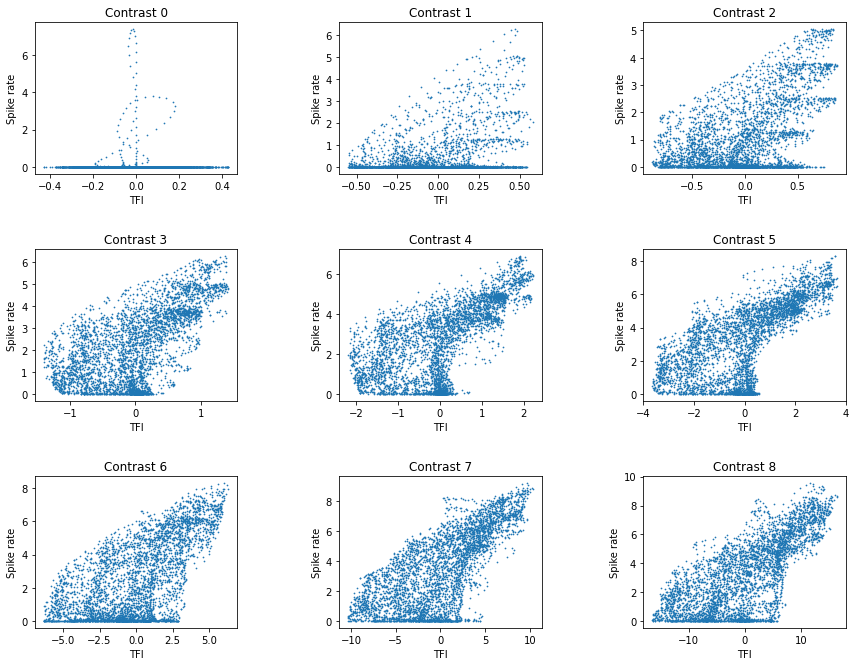

In [16]:
fig,axs = plt.subplots(3,3)
fig.set_figheight(9)
fig.set_figwidth(12)
fig.tight_layout()
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.5, hspace=0.5)
for i in range(9):
  j = i%3
  k = int(i/3)
  axs[k][j].scatter(filtered_data_sta_final[i][0:40000:10],filtered_data_final[i][0:40000:10],s = 0.5)
  axs[k][j].set_title('Contrast ' + str(i))
  axs[k][j].set_xlabel('TFI')
  axs[k][j].set_ylabel('Spike rate')

**(d) Average the points in your scatter plot over the x-axis until it is possible to draw a nice graph of the
nonlinearity for all nine trials. You want each value of x in your graph to correspond to a single value of y.
(You should aim for 20-40 points along the x-axis) What do you observe when you compare the nonlinearities
for the different intensities?**

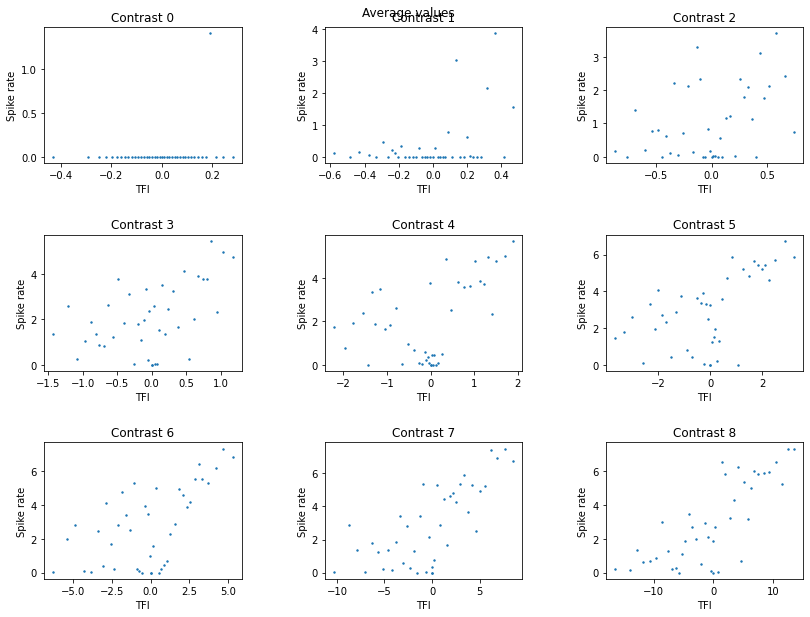

In [17]:
x_new = []
y_new = []
x_data_final = []
y_data_final = []
imp_x = []
fig,axs = plt.subplots(3,3)
fig.tight_layout()
fig.set_figheight(9)
fig.set_figwidth(12)
fig.suptitle('Average values')

for i in range(9):
  
  temp_arr = np.sort(filtered_data_sta_final[i])
  
  for n in range(0,200000,int(200000/40)):
    imp_x.append(temp_arr[n])
  
  x_new = []
  y_new = []
  
  for x in imp_x:
    sum_y = 0
    temp_arr_indices = np.where(filtered_data_sta_final[i] == x)
    
    for j in temp_arr_indices[0]:
      if j<=200000:
        sum_y+=filtered_data_final[i][j]

    if len(temp_arr_indices[0])!=0:
      y_new.append(sum_y/(len(temp_arr_indices[0])))
      x_new.append(x)
    
  k = i%3
  l = int(i/3)
  axs[l][k].scatter(x_new,y_new,s = 2)
  axs[l][k].set_title('Contrast ' + str(i))
  axs[l][k].set_xlabel('TFI')
  axs[l][k].set_ylabel('Spike rate')
 
  x_data_final.append(x_new)
  #print(x_new)
  y_data_final.append(y_new)

**Ans.** We see that for lower contrasts, the non linearities are lesser, but as the contrast increases, we see a clear shift in the graph.

**(e) Apply your estimated nonlinearity to the filter output to generate the model’s predicted firing rate. This
can be done with the interp1 command. interp1(x,y,x0) interpolates between a list of (x, y) points to
give the function values at the points x0. (x,y) will be the points on the nonlinearity that you found in
problem 2d, and x0 will be the full filter output. Plot your result together with the actual firing rate. Is the
linear-nonlinear model a fair description of the response of the neuron? Check different contrast intensities.**

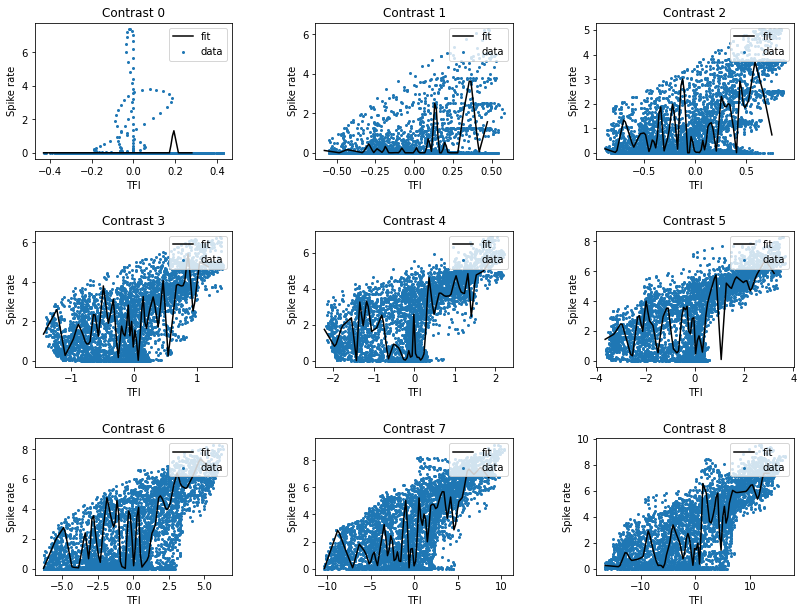

In [18]:
fig, axs = plt.subplots(3,3)
fig.tight_layout()
fig.set_figheight(9)
fig.set_figwidth(12)
for i in range(9):

  f = interpolate.interp1d(x_data_final[i],y_data_final[i])

  x_plot = np.linspace(min(x_data_final[i]),max(x_data_final[i]),100)
  y_plot = f(x_plot)

  j = i%3
  k = int(i/3)
  axs[k][j].scatter(filtered_data_sta_final[i][:40000:10],filtered_data_final[i][:40000:10],s = 4,label = 'data')
  axs[k][j].plot(x_plot,y_plot,'k',label = 'fit')
  axs[k][j].legend(loc = 1)
  axs[k][j].set_title('Contrast ' + str(i))
  axs[k][j].set_xlabel('TFI')
  axs[k][j].set_ylabel('Spike rate')

**Ans.** We can see that as the contrast increases, the model performs better. The linear non linear model seems to be a good fit to the response of the neuron

This next part was done out of curiosity. Trying to fit a quadratic function to the data

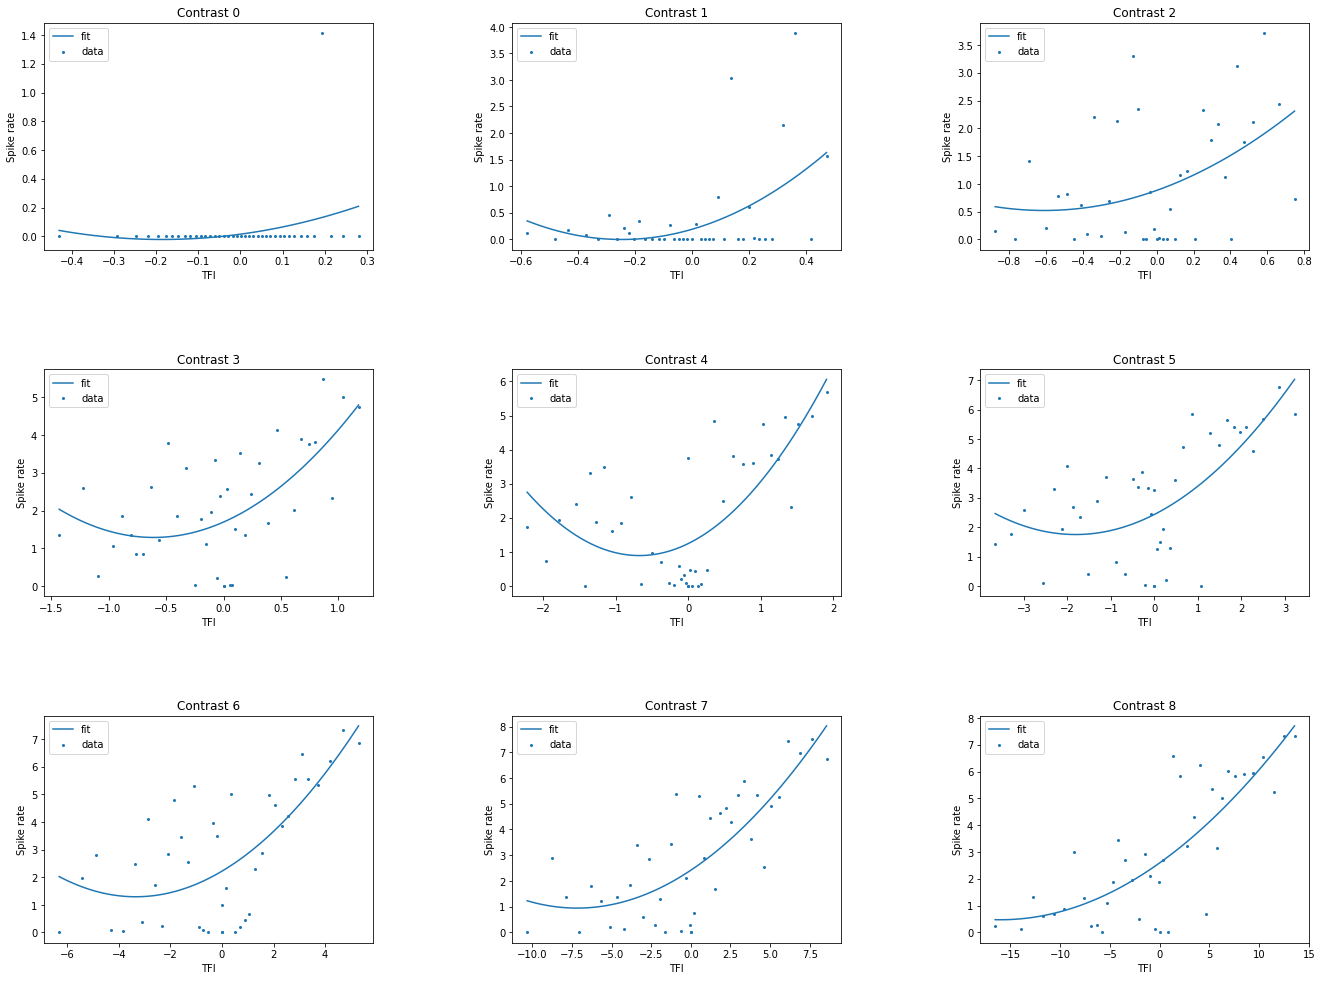

In [19]:
fig, axs = plt.subplots(3,3)
fig.tight_layout()
fig.set_figheight(15)
fig.set_figwidth(20)

for i in range(9):

  f = np.poly1d(np.polyfit(x_data_final[i],y_data_final[i],2))

  x_plot = np.linspace(min(x_data_final[i]),max(x_data_final[i]),100)
  y_plot = f(x_plot)

  j = i%3
  k = int(i/3)
  axs[k][j].plot(x_plot,y_plot,label = 'fit')
  axs[k][j].scatter(x_data_final[i],y_data_final[i],s = 4,label = 'data')
  axs[k][j].legend()
  axs[k][j].set_title('Contrast ' + str(i))
  axs[k][j].set_xlabel('TFI')
  axs[k][j].set_ylabel('Spike rate')

# Question 3

**(a) Construct the spatial part of a vertically oriented V1 simple cell using function 2.27. Use the values
from figure 2.15, as we will need them later. In particular, pick the special case k = 1 and σx = σy = σ = 2.
Take the phase φ = 0 as given in figure 2.15. Make plots of your spatial receptive field equivalent to figure
2.10 A. Instead of doing a contour plot, you can also make a color image (MATLAB function image) where
different colors (or brightnesses) correspond to the bright or dark sensitive areas of the receptive field. The
image function of MATLAB operates in a certain number range, so you probably have to scale your values
to make the image visible. You can use help image to see alternative functions for plotting as well (e.g.
imshow, imagesc, etc; in Python, matplotlib has a similar imshow function) Use whichever one works best
for you.**

In [20]:
def gabor_func(x,y,k,sig_x,sig_y,phi):
  ans = (1/(2*math.pi*sig_x*sig_y)) * math.exp( ( - ( (x**2)/( 2*( sig_x**2 ) ) ) - ( (y**2)/( 2*( sig_y**2 ) ) ) )) * math.cos(k*x-phi)
  return ans

def img_array(x,y,k,sig_x,sig_y,phi):
  img_arr = np.zeros([2*y+1,2*x+1])
  for j in range(-y,y+1):
    for i in range(-x,x+1):
      #print(i)
      img_arr[j+y][i+x] = gabor_func(i,j,k,sig_x,sig_y,phi)
      #print(img_arr)
  return img_arr

Text(0.5, 1.0, 'Spacial Receptive field - colour image')

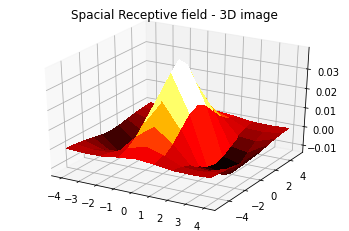

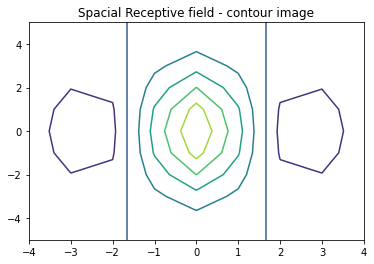

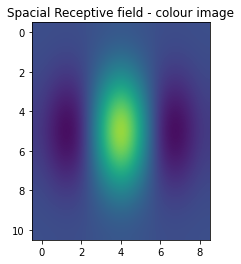

In [21]:
from matplotlib.colors import Normalize
img_arr = img_array(4,5,1,2,2,0)
x=np.arange(-4,5)
y= np.arange(-5,6)
X,Y =np.meshgrid(x,y)
#print(img_arr)
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

surf = ax.plot_surface(X, Y, img_arr, cmap = 'hot', linewidth=0, antialiased=False)
ax.set_title('Spacial Receptive field - 3D image')
plt.figure(2)
plt.contour(X,Y,img_arr)
plt.title('Spacial Receptive field - contour image')
plt.figure(4)
plt.imshow(img_arr,interpolation='bicubic')
plt.title('Spacial Receptive field - colour image')

**(b) Construct the temporal part of the corresponding receptive field as given in formula 2.29. Use
α = 1/(15ms). Convince yourself that you get a graph qualitatively equivalent to figure 2.14.**

In [22]:
def temporal_field(alpha,tau):
  ans = alpha*math.exp(-alpha*tau)* ( (( ( alpha*tau )**5 )/ (math.factorial( 5 ) )) - (  ( ( alpha*tau )**7 )/ (math.factorial( 7 ) ) ) )
  return ans

Text(0.5, 1.0, 'Temporal structure of receptive field')

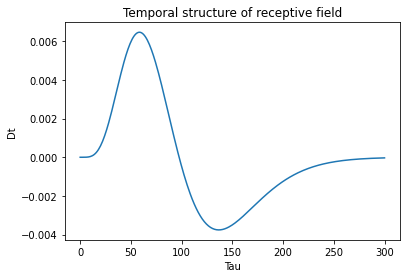

In [23]:
temp_arr =[]
for i in range(300):
  temp_arr.append(temporal_field(1/15,i))
#print(temp_arr)
temp_arr = temp_arr[::-1]
x_arr = np.linspace(0,300,300)
plt.plot(x_arr[::-1],temp_arr)
plt.xlabel('Tau')
plt.ylabel('Dt')
plt.title('Temporal structure of receptive field')

**(c) Combine the spatial and the temporal parts of your receptive field (according to 2.a) to get a spa-
tiotemporal field. Make a series of plots similar to figure 2.13 to see the temporal dynamics of your receptive
field.
Now we want to construct the stimulus (a counterphase sinusoidal grating) according to equation 2.18.
4**

In [24]:
def spatiotemporal(dxy,dt):
  return dxy*dt

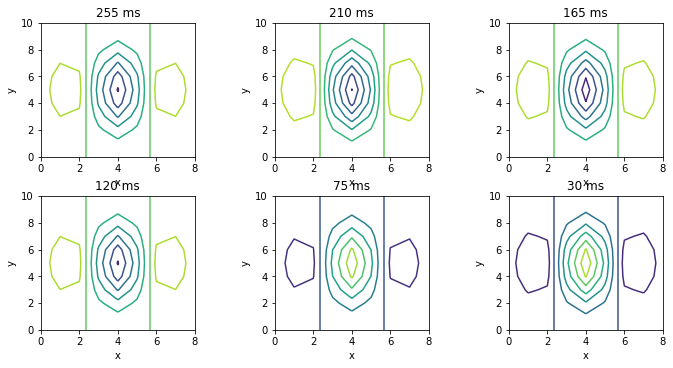

In [25]:
t = [255,210,165,120,75,30]
fig,axs = plt.subplots(2,3)
fig.tight_layout()
fig.set_figheight(5)
fig.set_figwidth(10)
j=0
k=0
for i in t:
  temp_tau = temporal_field(1/15,i)
  axs[k,j].contour(spatiotemporal(img_arr,temp_tau))
  axs[k,j].set_title(str(i)+' ms')
  axs[k,j].set_xlabel('x')
  axs[k,j].set_ylabel('y')
  j+=1
  if j ==3:
    k+=1
    j=0
#fig.colorbar(axs[1,1])

**(d) Construct the counterphase sinusoidal grating according to function 2.18. Have a look at your result
by producing some pictures (using the image function of MATLAB), varying Θ or K. Keep t = 0 for the
moment. You should get a picture similar to figure 2.8 A. Now convince yourself that the grating is oscillating
by making a small “movie”. (You can do this in MATLAB by having a loop where you change t and update
your image in every iteration, use the pause(sec) function to slow the movie down. In Python, matplotlib
has a feature called FuncAnimation that can help with this. To make it work in a Jupyter notebook,
FuncAnimation can give you an HTML5 video if you set the “animation.html” parameter in rcParams to
“html5”. You may need to install ffmpeg via Anaconda to make this work properly.)
Now we want to test the linear response of our model V1 neuron to a counterphase sinusoidal grating
stimulus.**

In [26]:
def sin_grating(x,y,theta,phi,t,A,K,omega):
  ans = A * math.cos(K*x*math.cos(theta)+K*y*math.sin(theta) - phi)*math.cos(omega*t)
  return ans

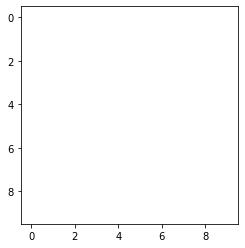

In [27]:
fig,ax = plt.subplots()

ims = []
sin_arr = np.zeros([10,10])

for k in range(60):
  for j in range(10):
    for i in range(10):
      sin_arr[j][i] = sin_grating(i,j,k,0,0,1,1,3)
  im = ax.imshow(sin_arr,cmap ='gray',animated = True)
  if i == 0:
        ax.imshow(sin_arr,cmap='gray')
  ims.append([im])


ani = animation.ArtistAnimation(fig, ims, interval=100, blit=True,
                                repeat_delay=1000)

# blit=True re-draws only the parts that have changed.
#anim = animation.FuncAnimation(fig, drawframe, frames=4, interval=20, blit=True)

# x = np.arange(100)
# y = np.arange(100)
# sin_arr = np.zeros([100,100])
# for j in range(len(y)):
#   for i in range(len(x)):
#     sin_arr[j][i] = sin_grating(i,j,1.57,3,0,5,5,3)
  
# plt.imshow(sin_arr,cmap = 'gray')

In [28]:
from IPython.display import HTML
HTML(ani.to_html5_video())

**(e) Test the selectivity (linear response functions) of the spatial part of the V1 receptive field (we can
do that separately because the spatial and temporal part separate as we saw in equation 2.a. To test the
selectivity of the receptive field we have to use it as a filter over the stimulus. This is exactly what equation
2.31 is saying. Reproduce the figures 2.15 A, B and C. Remember that we put k = 1 and σ = 2. To produce
the graphs you have to numerically integrate equation 2.31. To get the orientation response (figure A) you
have to set K = k and Φ = 0 and vary the parameter Θ as described in the figure. To get the spatial
frequency response (figure B) you have to set Φ = 0 and Θ = 0 and vary K. To get the spacial phase
response you have to set K = k and Θ = 0 and vary Φ. Be sure to use appropriate integration limits! You
do not want to cut essential parts of the receptive field, nor do you want to integrate up to infinity!
Hint: Numerical integration simply adds up all the elements of your filter and stimulus, and multiplies
them by the dxdy term. To see this, replace the integral in Eq. 2.31 or 2.32 with a summation over each
element in your matrix.**

Text(27.125, 0.5, 'Ls')

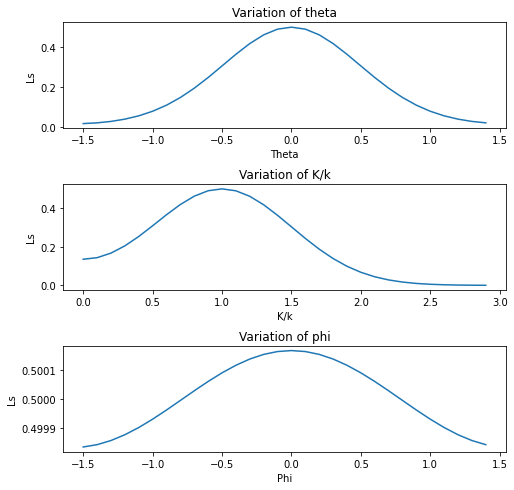

In [29]:
theta = 0
phi = 0
k = 1
K = 1
g_f = lambda x,y : gabor_func(x,y,k,2,2,phi)
p_2 = lambda x,y : 1*math.cos(K*x*math.cos(theta) + K*y*math.sin(theta) - phi)

fig, ax = plt.subplots(3)
fig.tight_layout()
fig.set_figheight(7)
fig.set_figwidth(7)

theta_arr = np.arange(-1.5,1.5,0.1)
int_arr = []
for i in theta_arr:
  theta = i
  l_s = lambda y,x : g_f(x,y)*p_2(x,y)
  ans = integrate.dblquad(l_s, -10, 10, lambda x: -10, lambda x: 10)
  int_arr.append(ans[0])

ax[0].plot(theta_arr,int_arr)
ax[0].set_title('Variation of theta')
ax[0].set_xlabel('Theta')
ax[0].set_ylabel('Ls')

theta = 0

K_arr = np.arange(0,3,0.1)
int_arr = []
for i in K_arr:
  K = i
  #print(K/k)
  l_s = lambda y,x : g_f(x,y)*p_2(x,y)
  ans = integrate.dblquad(l_s, -10, 10, lambda x: -10, lambda x: 10)
  int_arr.append(ans[0])

ax[1].plot(K_arr,int_arr)
ax[1].set_title('Variation of K/k')
ax[1].set_xlabel('K/k')
ax[1].set_ylabel('Ls')

K = k

phi_arr = np.arange(-1.5,1.5,0.1)
int_arr = []
for i in phi_arr:
  phi = i
  l_s = lambda y,x : g_f(x,y)*p_2(x,y)
  ans = integrate.dblquad(l_s, -10, 10, lambda x: -10, lambda x: 10)
  int_arr.append(ans[0])

ax[2].plot(phi_arr,int_arr)
ax[2].set_title('Variation of phi')
ax[2].set_xlabel('Phi')
ax[2].set_ylabel('Ls')

**(f) Test the frequency part of the receptive field selectivity. Because the temporal and the spatial part of
the receptive field separate, we can use only the temporal part 2.29 as a filter. Equation 2.32 shows us how
the temporal part of the stimulus is filtered by the temporal part of the receptive field. Take into account
that our unit for ω/2π is kHz, because we measure times in ms. The range of frequencies depicted in figure
2.16 corresponds in our case to values ω = 0...2π ·0.02. The output Lt(t) will now be oscillating in time.
To get a plot like figure 2.16, you have to extract the amplitude of these oscillations. Be sure to use a long
enough stimulus sequence (especially for low ω!) to get at least one full oscillation to measure its amplitude.
Use α = 1/(15ms). Be sure to use appropriate integration boundaries as in the case of the spatial part!**

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in double_scalars
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/numpy/core/function_base.py:151: RuntimeWarning: invalid value encountered in multiply
  y *= step
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in double_scalars
  


Text(0.5, 1.0, 'Amplitude vs frequency')

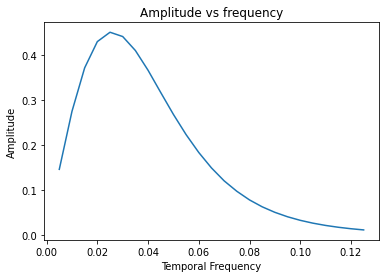

In [30]:
alpha =1/15
t = 20
omega = 0
int_arr =[]
final_arr = []
int2_arr = []

i_f = lambda tau : temporal_field(alpha,tau) * math.cos(omega*(t-tau))

om_arr = np.arange(0,2*math.pi*0.02,0.005)
for om in om_arr:
  omega = om
  t_arr = np.linspace(0,100/(omega),50)
  int2_arr = []
  for t_new in t_arr:
    t = t_new
    int2_arr.append(integrate.quad(i_f,0,np.inf)[0])
    #plt.plot(int2_arr)
  int_arr.append(max(int2_arr))
  #int_arr.append(integrate.quad(i_f,0,np.inf)[0])
  #plt.plot(int_arr)
  #print(int_arr)
plt.figure()
plt.plot(om_arr,int_arr)
plt.xlabel('Temporal Frequency')
plt.ylabel('Amplitude')
plt.title('Amplitude vs frequency')